# CNN-LSTM combination
##Both models work "independently" and then the outputs of the 2 are concatenated and fed into a FC layers.


#Mounting GD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Utils used for experiments
##On the final stage, those are to be inlcuded in a separate .py file

In [ ]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras

Modified labels


Vizualizing MFCCs and wave 

#Loading pre-computed features and corresponding labels

In [ ]:
import ast
featuresdf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release/features.csv",index_col=[0])
featuresdf['feature'] = featuresdf['feature'].apply(lambda x: np.array(ast.literal_eval(x))) 


##Converting features to numpy arrays


In [ ]:
features_temp = featuresdf['feature']
X = [l.tolist() for l in features_temp]
X = np.array(X)
X.shape

(5531, 40, 517)

Encode labels to onehot

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
rounded_labels

array(['ang', 'hap', 'neu', 'sad'], dtype='<U3')

#CNN-LSTM model
basically the idea is that both models work independently at a time and the output of 2 is concatenated in a single vector and passed to a FC network.
model = Model(inputs=X_input, outputs=X, name='ResNet50')
  
  model.add(Conv2D(filters = 64, kernel_size = 8, padding="same", activation='relu', input_shape = (40,517,1)))
  model.add(Dropout(0.1))
  model.add(Conv2D(filters = 64, kernel_size = 8, padding="same", activation='relu', input_shape = (40,517,1)))
  model.add(Dropout(0.1))
  model.add(Conv2D(filters = 128, kernel_size = 5, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters = 128, kernel_size = 5, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters = 256, kernel_size = 3, activation='relu'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(GlobalMaxPool2D())

In [ ]:
from keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.initializers import glorot_uniform
import tensorflow as tf
def convolutional_block(X, filters, block,kernel_size = 8, s=1):
    X = Conv2D(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(s, s), padding='same',activation="relu")(X)
    X = Dropout(0.1)(X)
    return X

def CNN_LSTM(classes=4, num_conv = 5):
    #Define CNN model
    #subject to changes
    cnn_input = Input(shape=(40,517,1), name="cnn-mfcc")
    cnn = convolutional_block(cnn_input,64,8)
    # cnn = convolutional_block(cnn,64,8)
    # cnn = convolutional_block(cnn,128,5)
    cnn = convolutional_block(cnn,128,5)
    cnn = convolutional_block(cnn,256,5)
    cnn = BatchNormalization()(cnn)
    cnn = GlobalMaxPooling2D()(cnn)
    cnn_output = Model(inputs = cnn_input, outputs = cnn)
    # cnn_input = convolutional_block(cnn_input,64,8)
    # for i in range(num_conv-1):
    #   if(i ==0 or i==1):
    #     cnn_input = convolutional_block(cnn_input,64,8)
    #   cnn_input = convolutional_block(cnn_input,64,5)
    # cnn_input = convolutional_block(cnn_input,64,3)
    # cnn_input = BatchNormalization()(cnn_input)
    # cnn_input = GlobalMaxPooling2D()(cnn_input)
    #Define LSTM model
    #subject to changes
    lstm_input = Input(shape=(517,40),name="lstm-mfcc")
    lstm = CuDNNLSTM(units=64,return_sequences=True)(lstm_input)
    lstm = CuDNNLSTM(units=64)(lstm)
    lstm = Dense(64,activation="relu")(lstm)
    lstm_output = Model(inputs = lstm_input, outputs = lstm)
    #merging temporal and spatial features extracted into a vector
    # feats = layers.concatenate([cnn_input,lstm_input],axis=1)
    feats =  tf.keras.layers.Concatenate()([cnn_output.output,lstm_output.output])
    feats = Dense(64, activation="relu")(feats)
    feats = Dropout(0.2)(feats)
    feats = Dense(64, activation="relu")(feats)
    prediction = Dense(classes, activation="softmax",name = "prediction")(feats)

    # Instantiate an end-to-end model 
    model = Model(
        inputs=[cnn_output.input, lstm_output.input],
        outputs=[prediction],
    )
    return model

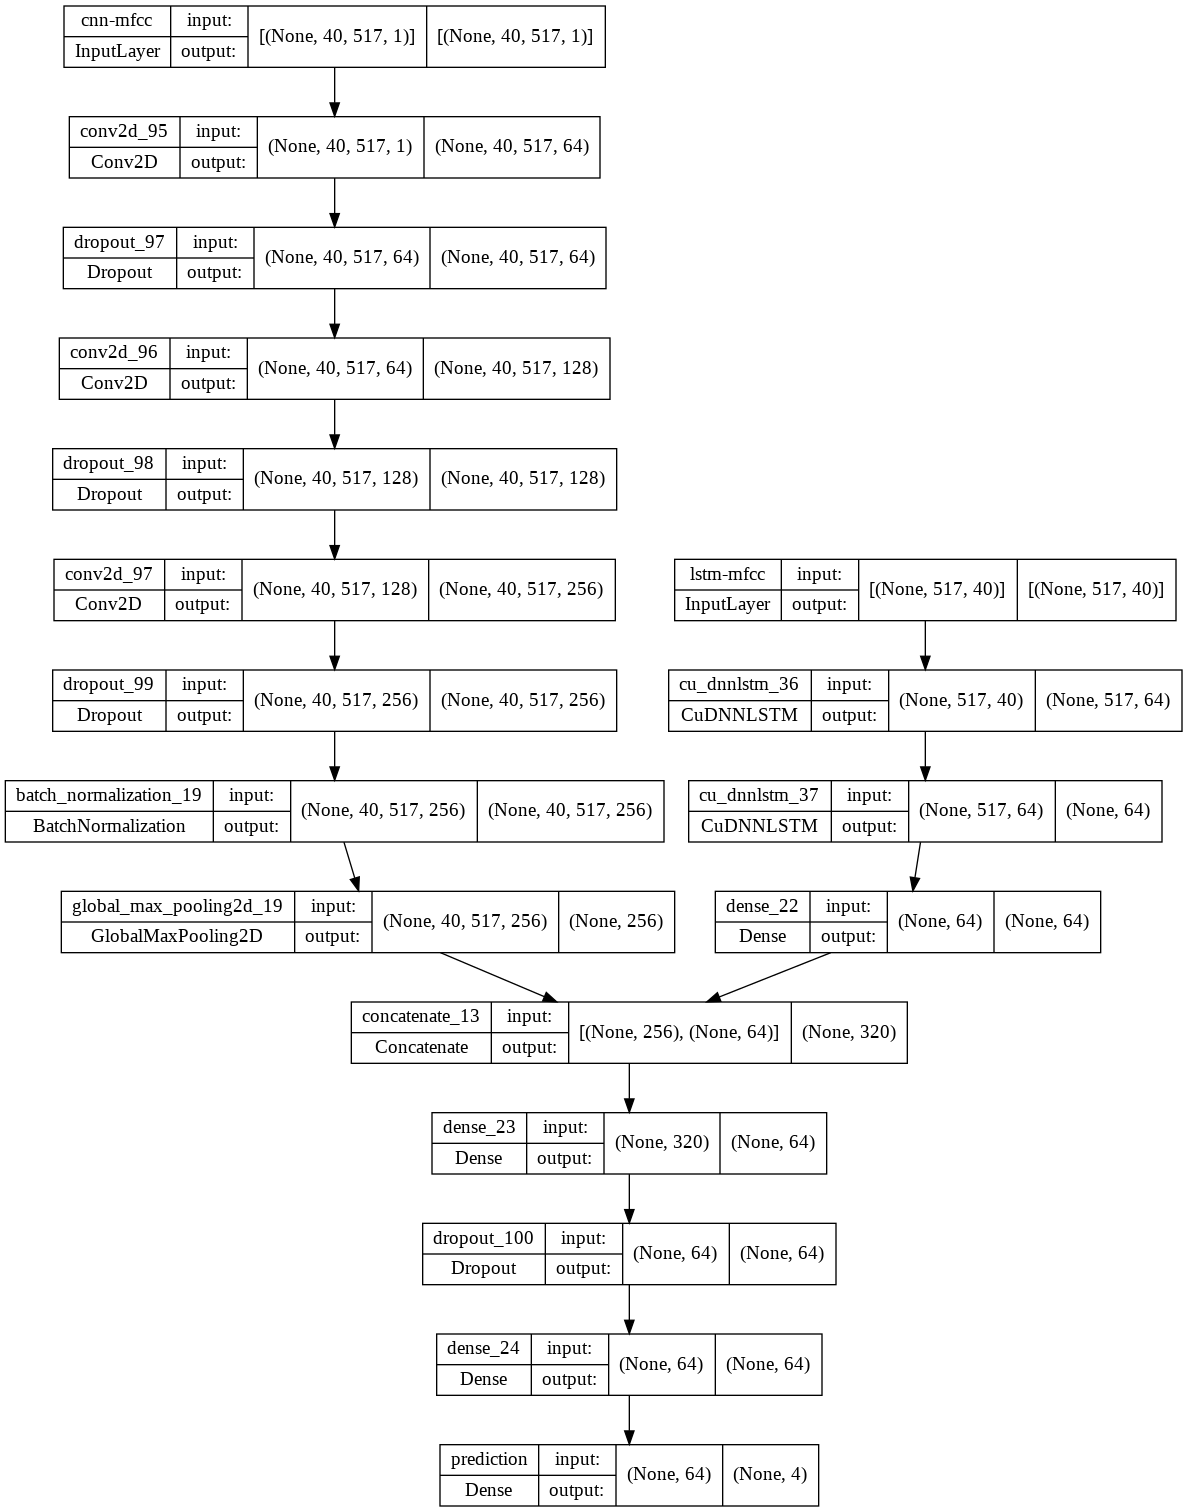

In [ ]:
keras.utils.plot_model(CNN_LSTM(), "/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/cnnlstm.png", show_shapes=True)

In [ ]:
def k_fold_fit_re(model_type, X, yy, lr = 0.0001, folds=10, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import KFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.metrics import f1_score
  from functools import reduce
  #pred and ground truth for overall conf matrix
  truth = []
  predicted = []
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  #Transpose input for lstm 
  X1 = np.transpose(X,(0,2,1))

  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(X, yy):
    model = CNN_LSTM()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model

    history = model.fit({"cnn-mfcc": X[train], "lstm-mfcc": X1[train]},
                yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate({"cnn-mfcc": X[test], "lstm-mfcc": X1[test]}, yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix construction
    y_pred = np.argmax(model.predict({"cnn-mfcc": X[test], "lstm-mfcc": X1[test]}), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #append predicted and ground truth to corresponding lists
    truth.append(yy[test].argmax(axis=1).tolist())
    predicted.append(y_pred.tolist())
    #conf matrix contd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')
  #flatten the nested lists
  print('Confusion matrix over all folders')
  truth = reduce(lambda x,y: x+y, truth)
  predicted = reduce(lambda x,y:x+y, predicted)
  matrix = metrics.confusion_matrix(truth, predicted)
  rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
156/156 [==============================] - 80s 454ms/step - loss: 1.8521 - accuracy: 0.3406
Epoch 2/100
156/156 [==============================] - 68s 438ms/step - loss: 1.2301 - accuracy: 0.4018
Epoch 3/100
156/156 [==============================] - 68s 438ms/step - loss: 1.2065 - accuracy: 0.3988
Epoch 4/100
156/156 [==============================] - 68s 438ms/step - loss: 1.1833 - accuracy: 0.4215
Epoch 5/100
156/156 [==============================] - 68s 439ms/step - loss: 1.1569 - accuracy: 0.4434
Epoch 6/100
156/156 [==============================] - 68s 439ms/step - loss: 1.1276 - accuracy: 0.4571
Epoch 7/100
156/156 [==============================] - 68s 438ms/step - loss: 1.1439 - accuracy: 0.4539
Epoch 8/100
156/156 [==============================] - 68s 438ms/step - loss: 1.1120 - accuracy: 0.4649
Epoch 9/100
156/156 [==============================] - 68s 438ms/step -

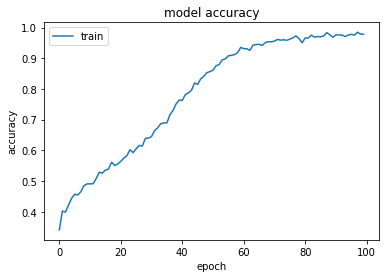

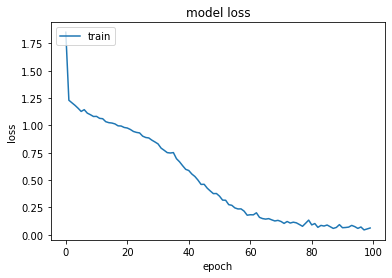

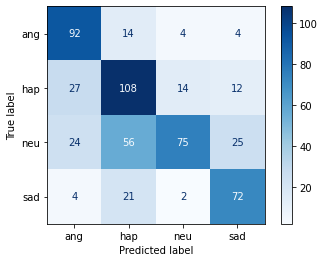

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.635380029678345 (+- 0.0)
> Loss: 2.0817513465881348
> F1: 61.804136695422415
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
156/156 [==============================] - 73s 455ms/step - loss: 1.9118 - accuracy: 0.3319
Epoch 2/100
156/156 [==============================] - 68s 437ms/step - loss: 1.2491 - accuracy: 0.3855
Epoch 3/100
156/156 [==============================] - 68s 438ms/step - loss: 1.2166 - accuracy: 0.4136
Epoch 4/100
156/156 [==============================] - 68s 437ms/step

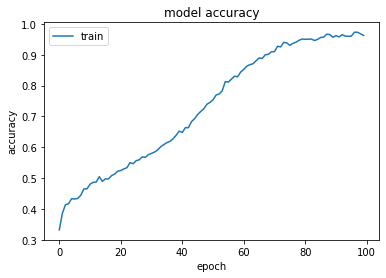

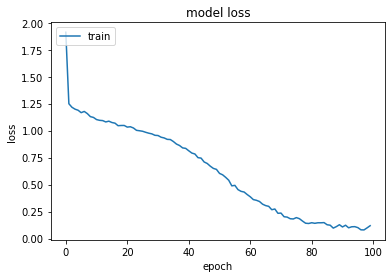

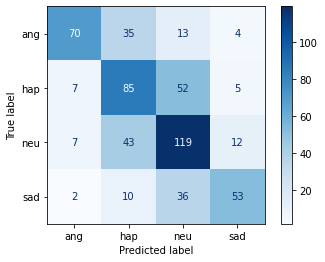

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 60.883694887161255 (+- 1.7516851425170898)
> Loss: 1.9766644835472107
> F1: 60.683583506936465
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
156/156 [==============================] - 70s 435ms/step - loss: 1.9189 - accuracy: 0.2915
Epoch 2/100
156/156 [==============================] - 68s 436ms/step - loss: 1.3109 - accuracy:

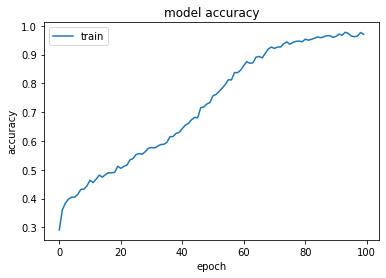

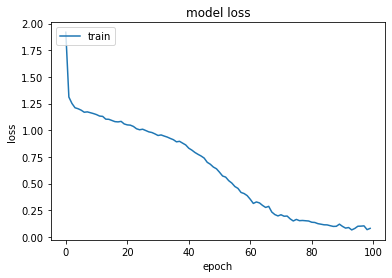

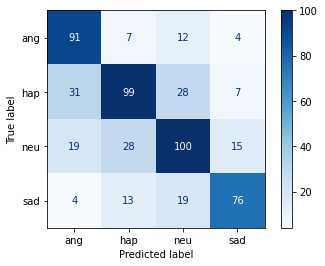

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.65061299006144 (+- 2.8791664980898326)
> Loss: 1.8459792137145996
> F1: 62.47535029926312
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
156/156 [=================

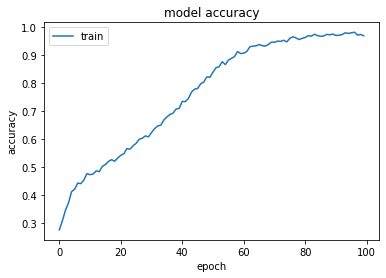

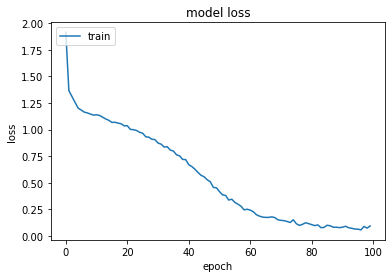

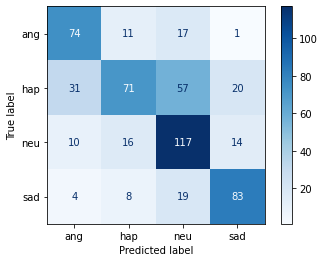

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
> Fold 4 - Loss: 2.0071756839752197 - Accuracy: 62.386977672576904% - F1: 61.396951054343795
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.58470416069031 (+- 2.4960432115969815)
> Loss: 1.8862783312797546
> F1: 62.20575048803329
------------------------------------------

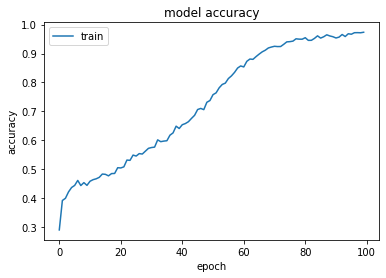

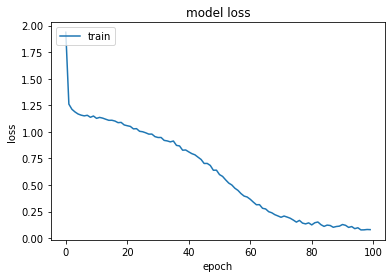

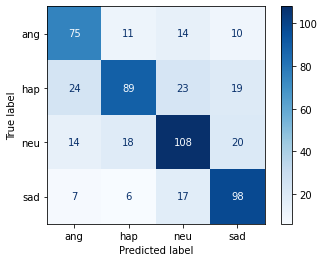

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
> Fold 4 - Loss: 2.0071756839752197 - Accuracy: 62.386977672576904% - F1: 61.396951054343795
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6894373893737793 - Accuracy: 66.90777540206909% - F1: 66.76063341398665
------------------------------------------------------------------------
Average score

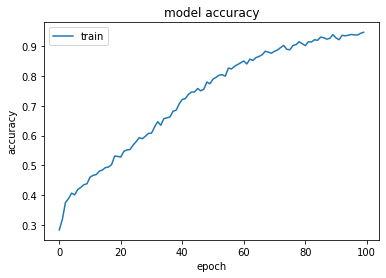

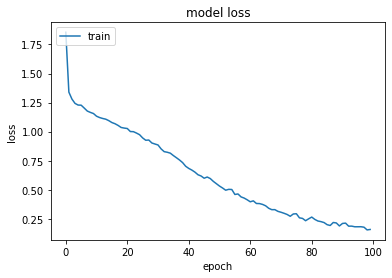

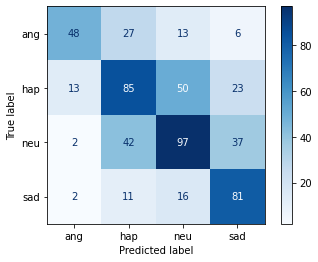

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
> Fold 4 - Loss: 2.0071756839752197 - Accuracy: 62.386977672576904% - F1: 61.396951054343795
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6894373893737793 - Accuracy: 66.90777540206909% - F1: 66.76063341398665
------------------------------------------------------------------------
> Fold 6 - Lo

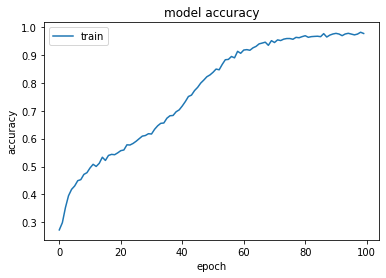

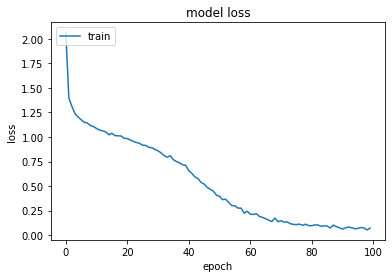

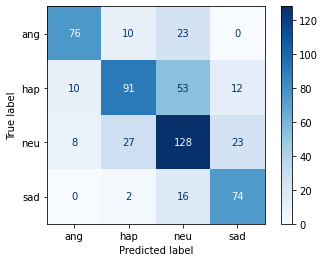

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
> Fold 4 - Loss: 2.0071756839752197 - Accuracy: 62.386977672576904% - F1: 61.396951054343795
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6894373893737793 - Accuracy: 66.90777540206909% - F1: 66.76063341398665
------------------------------------------------------------------------
> Fold 6 - Lo

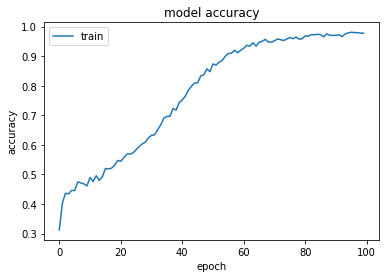

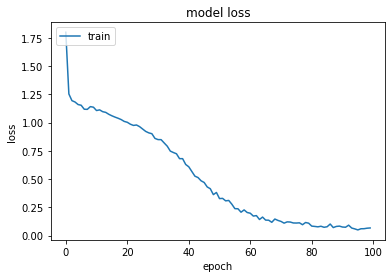

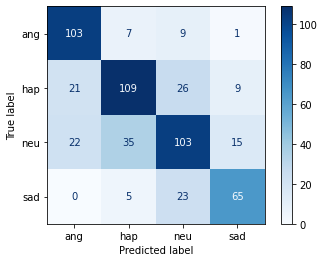

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
> Fold 4 - Loss: 2.0071756839752197 - Accuracy: 62.386977672576904% - F1: 61.396951054343795
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6894373893737793 - Accuracy: 66.90777540206909% - F1: 66.76063341398665
------------------------------------------------------------------------
> Fold 6 - Lo

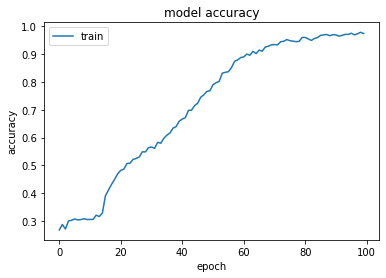

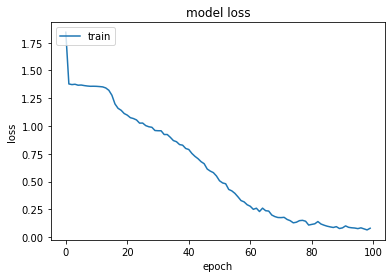

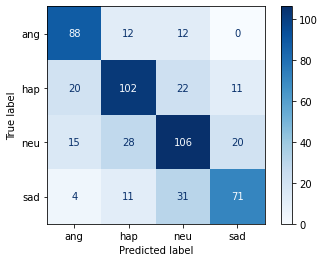

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 2.0817513465881348 - Accuracy: 62.635380029678345% - F1: 61.804136695422415
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8715776205062866 - Accuracy: 59.132009744644165% - F1: 59.563030318450515
------------------------------------------------------------------------
> Fold 3 - Loss: 1.5846086740493774 - Accuracy: 66.18444919586182% - F1: 66.05888388391642
------------------------------------------------------------------------
> Fold 4 - Loss: 2.0071756839752197 - Accuracy: 62.386977672576904% - F1: 61.396951054343795
------------------------------------------------------------------------
> Fold 5 - Loss: 1.6894373893737793 - Accuracy: 66.90777540206909% - F1: 66.76063341398665
------------------------------------------------------------------------
> Fold 6 - Lo

In [ ]:
k_fold_fit_re('CNN-LSTM', X, yy, folds=10, numepoch = 100, batchsize = 32)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
156/156 [==============================] - 90s 451ms/step - loss: 1.8478 - accuracy: 0.2913
Epoch 2/100
156/156 [==============================] - 68s 435ms/step - loss: 1.2928 - accuracy: 0.3484
Epoch 3/100
156/156 [==============================] - 68s 435ms/step - loss: 1.2276 - accuracy: 0.3852
Epoch 4/100
156/156 [==============================] - 68s 435ms/step - loss: 1.1865 - accuracy: 0.4031
Epoch 5/100
156/156 [==============================] - 68s 435ms/step - loss: 1.1877 - accuracy: 0.4189
Epoch 6/100
156/156 [==============================] - 68s 435ms/step - loss: 1.1742 - accuracy: 0.4342
Epoch 7/100
156/156 [==============================] - 68s 435ms/step - loss: 1.1537 - accuracy: 0.4523
Epoch 8/100
156/156 [==============================] - 68s 435ms/step - loss: 1.1147 - accuracy: 0.4714
Epoch 9/100
156/156 [==============================] - 68s 435ms/step -

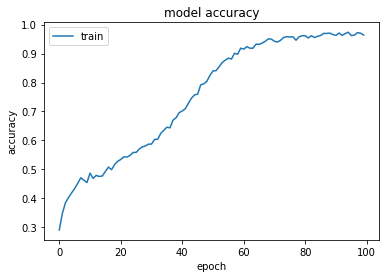

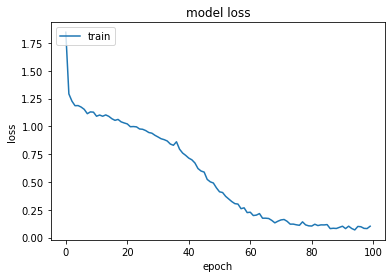

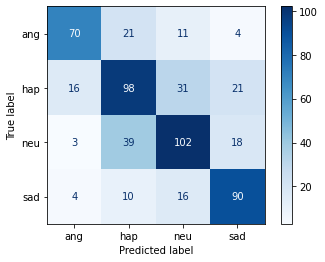

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.98194932937622 (+- 0.0)
> Loss: 1.7170958518981934
> F1: 64.98106000327071
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
156/156 [==============================] - 72s 453ms/step - loss: 1.8790 - accuracy: 0.2806
Epoch 2/100
156/156 [==============================] - 68s 436ms/step - loss: 1.3748 - accuracy: 0.3021
Epoch 3/100
156/156 [==============================] - 68s 435ms/step - loss: 1.3513 - accuracy: 0.3204
Epoch 4/100
156/156 [==============================] - 68s 435ms/step - l

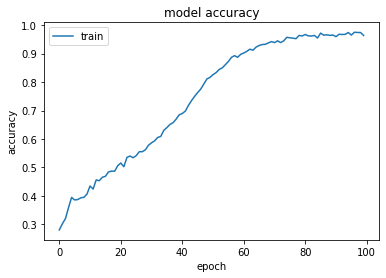

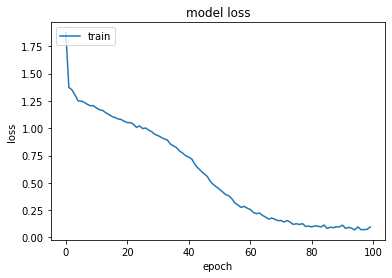

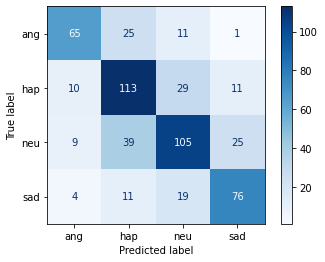

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.95028734207153 (+- 0.0316619873046875)
> Loss: 1.8487505316734314
> F1: 64.95136768022024
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
156/156 [==============================] - 70s 435ms/step - loss: 1.8742 - accuracy: 0.2873
Epoch 2/100
156/156 [==============================] - 68s 435ms/step - loss: 1.3656 - accuracy: 0.316

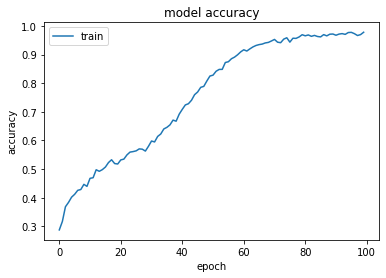

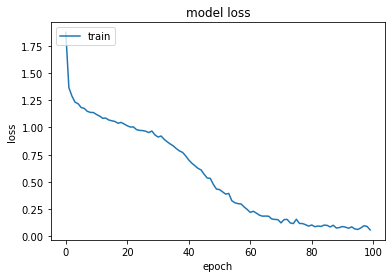

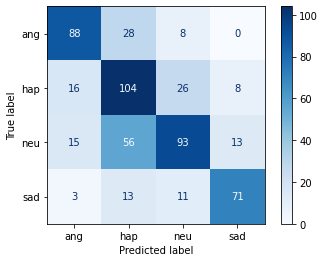

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.75890080134074 (+- 0.2718932454215344)
> Loss: 1.8343042532602947
> F1: 64.80198617182906
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
156/156 [======================

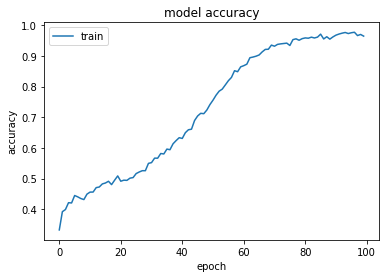

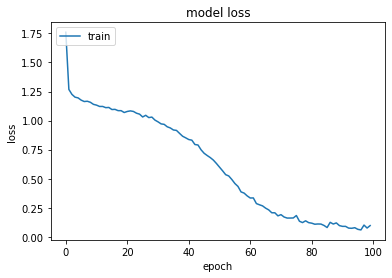

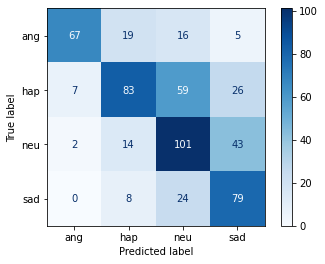

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.4878009557724 (+- 2.2141655098232738)
> Loss: 1.910947024822235
> F1: 63.597715368971414
---------------------------------------------------

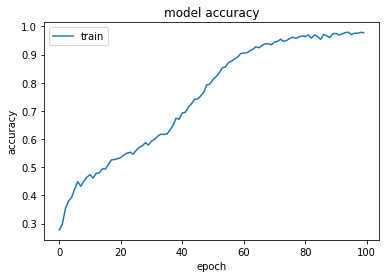

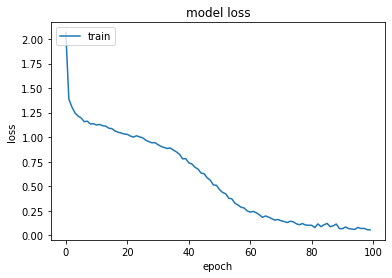

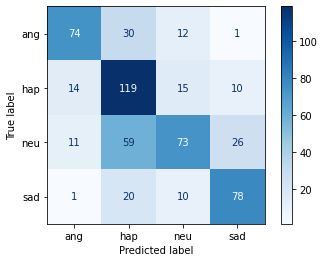

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9207476377487183 - Accuracy: 62.206149101257324% - F1: 61.76580730806326
------------------------------------------------------------------------
Average scores for a

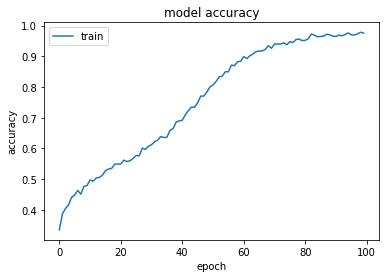

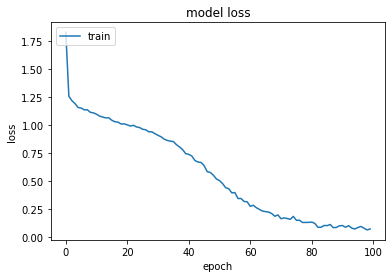

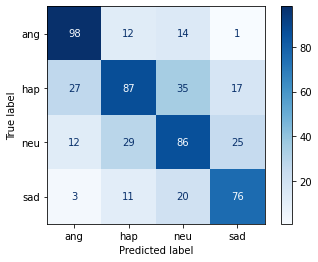

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9207476377487183 - Accuracy: 62.206149101257324% - F1: 61.76580730806326
------------------------------------------------------------------------
> Fold 6 - Loss: 1.8

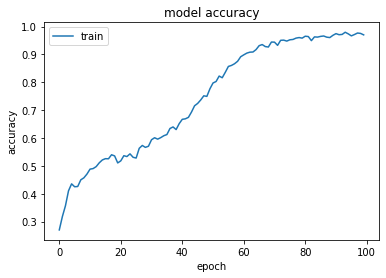

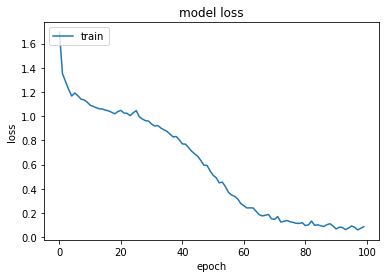

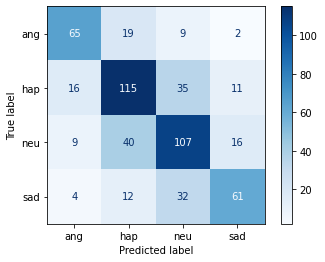

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9207476377487183 - Accuracy: 62.206149101257324% - F1: 61.76580730806326
------------------------------------------------------------------------
> Fold 6 - Loss: 1.8

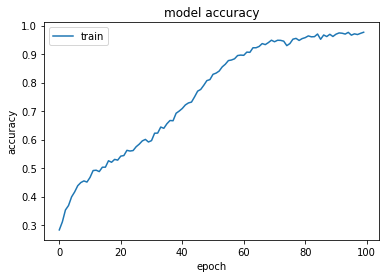

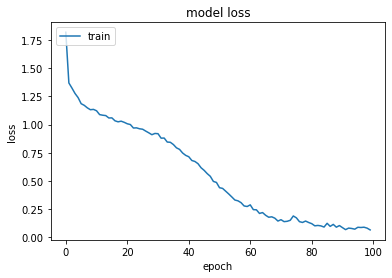

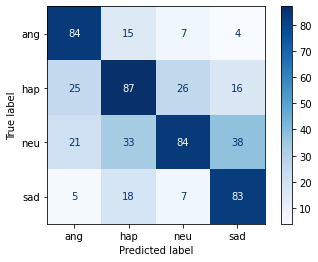

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9207476377487183 - Accuracy: 62.206149101257324% - F1: 61.76580730806326
------------------------------------------------------------------------
> Fold 6 - Loss: 1.8

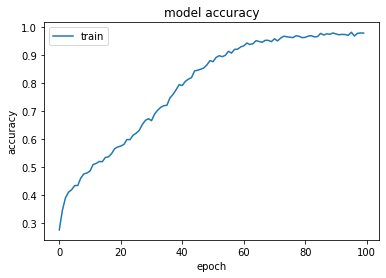

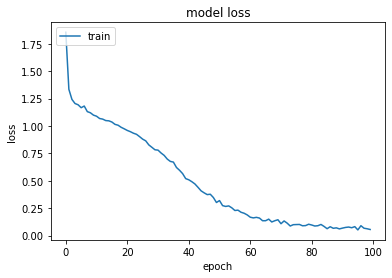

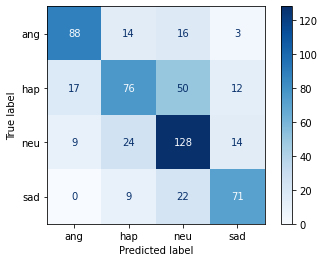

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9207476377487183 - Accuracy: 62.206149101257324% - F1: 61.76580730806326
------------------------------------------------------------------------
> Fold 6 - Loss: 1.8

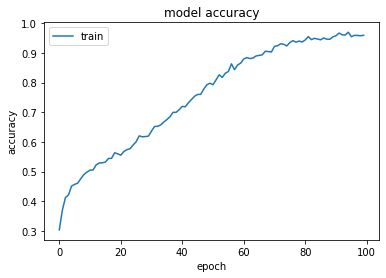

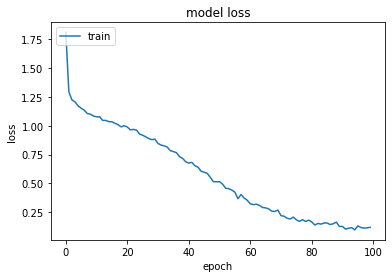

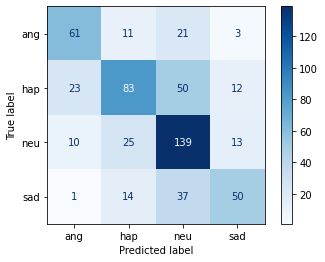

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7170958518981934 - Accuracy: 64.98194932937622% - F1: 64.98106000327071
------------------------------------------------------------------------
> Fold 2 - Loss: 1.9804052114486694 - Accuracy: 64.91862535476685% - F1: 64.92167535716979
------------------------------------------------------------------------
> Fold 3 - Loss: 1.805411696434021 - Accuracy: 64.37612771987915% - F1: 64.50322315504667
------------------------------------------------------------------------
> Fold 4 - Loss: 2.1408753395080566 - Accuracy: 59.67450141906738% - F1: 59.9849029603985
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9207476377487183 - Accuracy: 62.206149101257324% - F1: 61.76580730806326
------------------------------------------------------------------------
> Fold 6 - Loss: 1.8

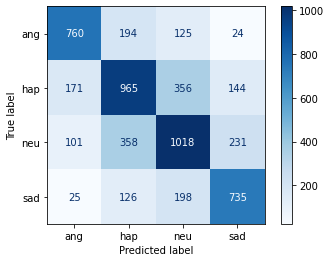

In [ ]:
k_fold_fit_re('CNN-LSTM', X, yy, folds=10, numepoch = 100, batchsize = 32)

In [ ]:
X.shape

(5531, 40, 517)

In [ ]:
def strat_k_fold_fit_re(model_type,X, yy, folds=10, lr=0.0001, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from sklearn.preprocessing import LabelEncoder
  from sklearn.metrics import f1_score
  le = LabelEncoder()
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  X1 = np.transpose(X,(0,2,1))
  # Define the stratified K-fold Cross Validator
  kfold = StratifiedKFold(n_splits=folds, shuffle=True)
  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, y):
    #label encoding comes after the split
    yy = to_categorical(le.fit_transform(y))
    model = CNN_LSTM()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model and save details to history
    history = model.fit({"cnn-mfcc": X[train], "lstm-mfcc": X1[train]},
                yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate({"cnn-mfcc": X[test], "lstm-mfcc": X1[test]}, yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix
    y_pred = np.argmax(model.predict({"cnn-mfcc": X[test], "lstm-mfcc": X1[test]}), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #conf matrix ctnd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
156/156 [==============================] - 90s 452ms/step - loss: 1.7174 - accuracy: 0.2853
Epoch 2/100
156/156 [==============================] - 68s 435ms/step - loss: 1.3672 - accuracy: 0.3092
Epoch 3/100
156/156 [==============================] - 68s 435ms/step - loss: 1.3641 - accuracy: 0.3030
Epoch 4/100
156/156 [==============================] - 68s 436ms/step - loss: 1.3575 - accuracy: 0.3241
Epoch 5/100
156/156 [==============================] - 68s 437ms/step - loss: 1.3557 - accuracy: 0.3293
Epoch 6/100
156/156 [==============================] - 68s 437ms/step - loss: 1.3449 - accuracy: 0.3307
Epoch 7/100
156/156 [==============================] - 68s 437ms/step - loss: 1.3228 - accuracy: 0.3613
Epoch 8/100
156/156 [==============================] - 68s 437ms/step - loss: 1.2747 - accuracy: 0.3892
Epoch 9/100
156/156 [==============================] - 68s 436ms/step -

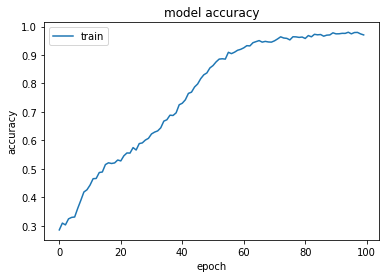

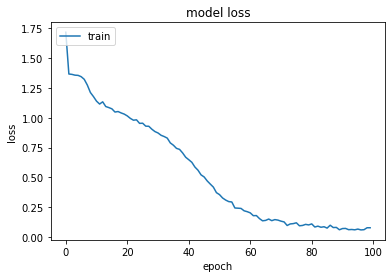

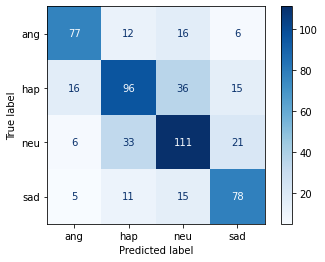

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.3429627418518 (+- 0.0)
> Loss: 1.7517855167388916
> F1: 65.32243172819831
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
156/156 [==============================] - 72s 453ms/step - loss: 1.9354 - accuracy: 0.2875
Epoch 2/100
156/156 [==============================] - 68s 435ms/step - loss: 1.3754 - accuracy: 0.3025
Epoch 3/100
156/156 [==============================] - 68s 436ms/step - loss: 1.3626 - accuracy: 0.3194
Epoch 4/100
156/156 [==============================] - 68s 436ms/step - lo

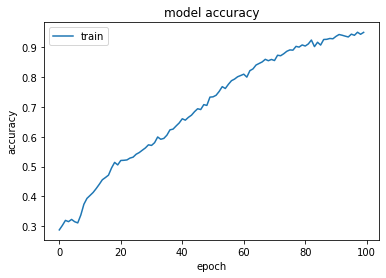

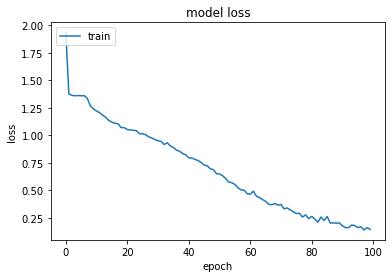

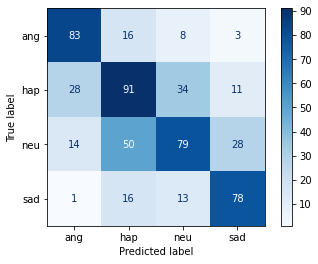

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 62.59914934635162 (+- 2.743813395500183)
> Loss: 1.8117287158966064
> F1: 62.35569666817691
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
156/156 [==============================] - 69s 435ms/step - loss: 1.8202 - accuracy: 0.3303
Epoch 2/100
156/156 [==============================] - 68s 435ms/step - loss: 1.2645 - accuracy: 0.378

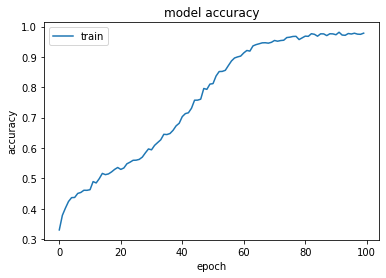

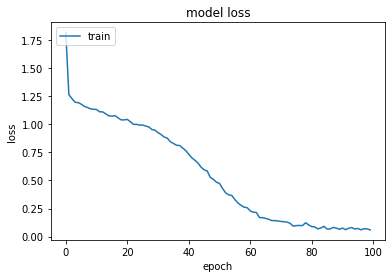

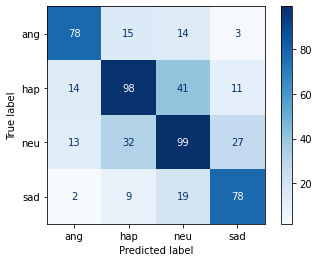

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.01064491271973 (+- 2.3146630788299856)
> Loss: 1.8209683100382488
> F1: 62.836575653525166
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
156/156 [==================

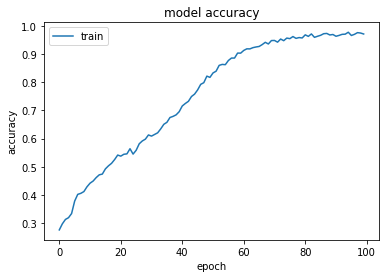

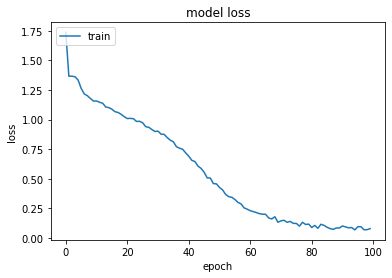

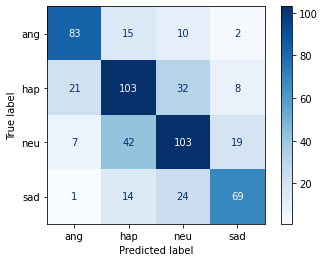

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 63.44243288040161 (+- 2.139525981024439)
> Loss: 1.8026983141899109
> F1: 63.31912757604775
-----------------------------------------------

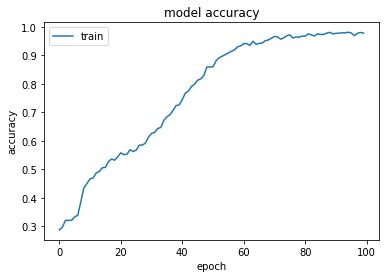

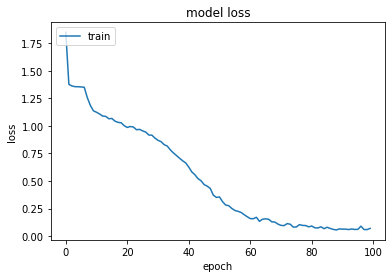

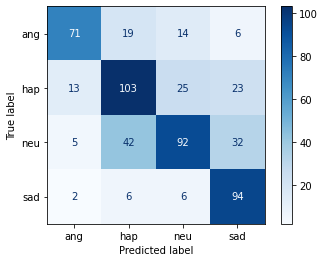

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9222412109375 - Accuracy: 65.0994598865509% - F1: 64.77730713440575%
------------------------------------------------------------------------
Average scores for a

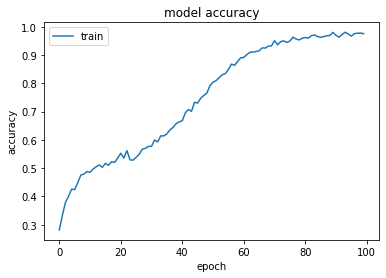

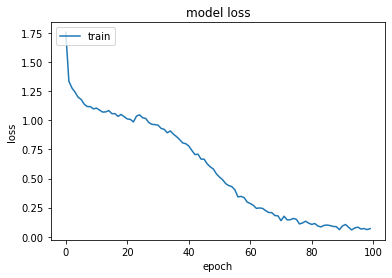

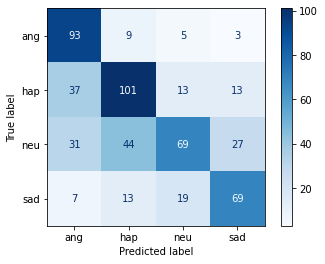

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9222412109375 - Accuracy: 65.0994598865509% - F1: 64.77730713440575%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.0

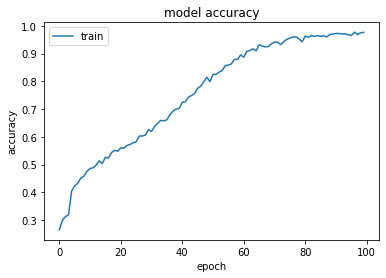

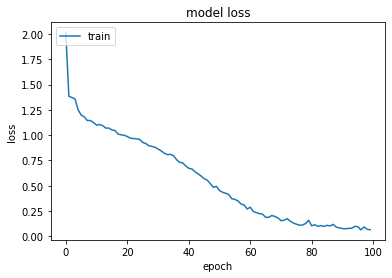

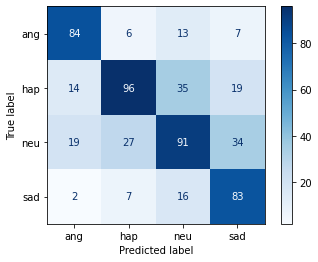

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9222412109375 - Accuracy: 65.0994598865509% - F1: 64.77730713440575%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.0

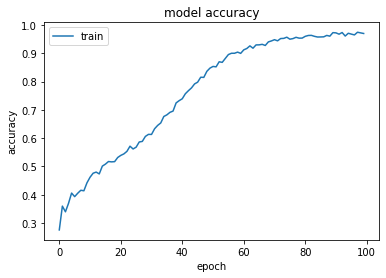

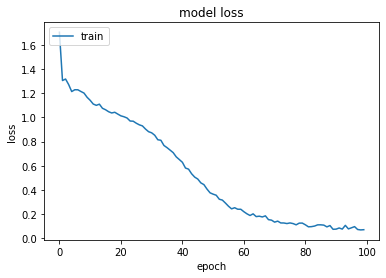

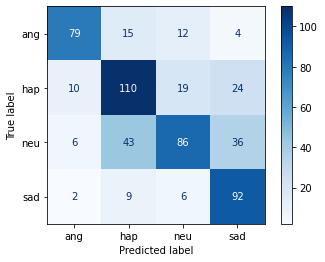

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9222412109375 - Accuracy: 65.0994598865509% - F1: 64.77730713440575%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.0

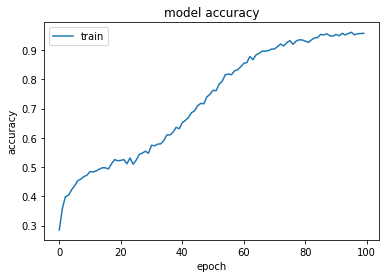

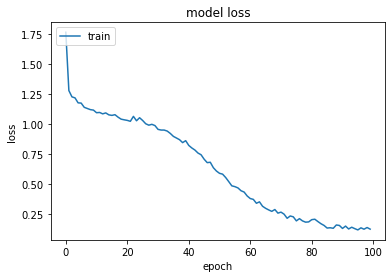

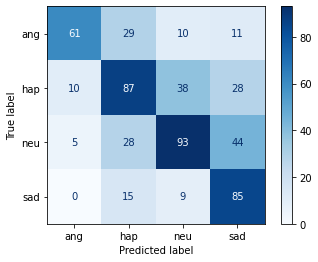

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9222412109375 - Accuracy: 65.0994598865509% - F1: 64.77730713440575%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.0

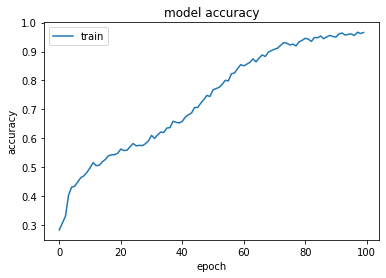

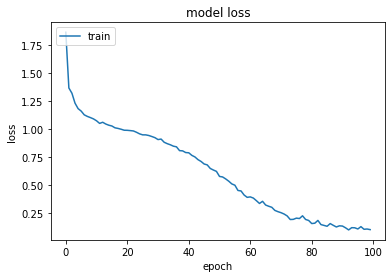

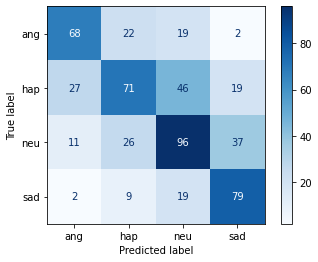

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.7517855167388916 - Accuracy: 65.3429627418518% - F1: 65.32243172819831%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.8716719150543213 - Accuracy: 59.85533595085144% - F1: 59.38896160815551%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.8394474983215332 - Accuracy: 63.83363604545593% - F1: 63.79833362422169%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.7478883266448975 - Accuracy: 64.73779678344727% - F1: 64.7667833436155%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.9222412109375 - Accuracy: 65.0994598865509% - F1: 64.77730713440575%
------------------------------------------------------------------------
> Fold 6 - Loss: 2.0

In [ ]:
strat_k_fold_fit_re('CNN-LSTM', X, yy, folds=10, numepoch = 100, batchsize = 32)

#Train over the whole dataset 80% with early stopping and model checkpoint callback

Basically it is a training with stratified "hold-out" approach for cross validation

In [ ]:
X.shape

(5531, 40, 517)

Epoch 1/150
139/139 [==============================] - ETA: 0s - loss: 2.0326 - accuracy: 0.2794
Epoch 1: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_cnnlstm.h5
139/139 [==============================] - 67s 469ms/step - loss: 2.0326 - accuracy: 0.2794 - val_loss: 1.4827 - val_accuracy: 0.2954
Epoch 2/150
139/139 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.3022
Epoch 2: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_cnnlstm.h5
139/139 [==============================] - 63s 454ms/step - loss: 1.3795 - accuracy: 0.3022 - val_loss: 1.4282 - val_accuracy: 0.2909
Epoch 3/150
139/139 [==============================] - ETA: 0s - loss: 1.3539 - accuracy: 0.3226
Epoch 3: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_cnnlstm.h5
139/139 [==============================] - 63s 454ms/step - loss: 1.3539 - accuracy: 0.3226 -

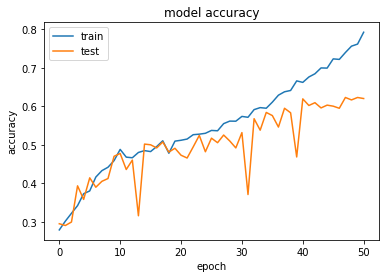

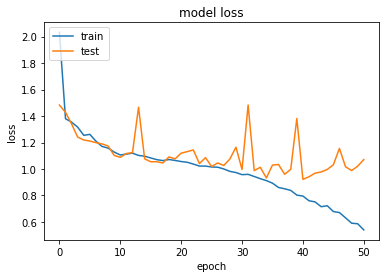

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
n_splits = 1  # We only want a single split in this case
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_cnnlstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=False)
for train_index, test_index in sss.split(X, y):
    X1 = np.transpose(X,(0,2,1))
    yy = to_categorical(le.fit_transform(y))
    X1_train, X1_test = X1[train_index], X1[test_index]
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    model = CNN_LSTM()
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit({"cnn-mfcc": X_train, "lstm-mfcc": X1_train},
                y_train,
                validation_data=({"cnn-mfcc": X_test, "lstm-mfcc": X1_test}, y_test),
                batch_size=32,
                epochs=150,
                verbose=1,
                callbacks=[es, mc])
    # history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=150, verbose=1, callbacks=[es, mc])
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
saved_model = load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_cnnlstm.h5')

#Training over the whole dataset 100 epochs

In [ ]:
X.shape

(5531, 40, 517)

In [ ]:
X1.shape

(5531, 517, 40)

In [ ]:
model = CNN_LSTM()
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit({"cnn-mfcc": X, "lstm-mfcc": X1},
            yy,
            batch_size=32,
            epochs=100,
            verbose=1)
model.save('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/cnnlstm.h5') 

Epoch 1/100
173/173 [==============================] - 84s 476ms/step - loss: 1.8853 - accuracy: 0.2663
Epoch 2/100
173/173 [==============================] - 75s 435ms/step - loss: 1.3142 - accuracy: 0.3432
Epoch 3/100
173/173 [==============================] - 75s 435ms/step - loss: 1.2397 - accuracy: 0.3983
Epoch 4/100
173/173 [==============================] - 75s 435ms/step - loss: 1.1992 - accuracy: 0.4068
Epoch 5/100
173/173 [==============================] - 75s 435ms/step - loss: 1.1631 - accuracy: 0.4370
Epoch 6/100
173/173 [==============================] - 75s 435ms/step - loss: 1.1538 - accuracy: 0.4440
Epoch 7/100
173/173 [==============================] - 75s 435ms/step - loss: 1.1432 - accuracy: 0.4534
Epoch 8/100
173/173 [==============================] - 75s 435ms/step - loss: 1.1176 - accuracy: 0.4663
Epoch 9/100
173/173 [==============================] - 75s 435ms/step - loss: 1.1017 - accuracy: 0.4789
Epoch 10/100
173/173 [==============================] - 75s 435m

#Application testing
Gonna find out what 'overfitted' models are capable of

In [ ]:
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 22050, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
import librosa.display
def record_audio():  
  audio, sr = get_audio()
  samples_orig = audio.shape[0]/48000
  print(f'duration is {samples_orig}')
  if(samples_orig > 12):
    audio = audio[:12*48000]
  else:
    N_pad = abs(12*48000-audio.shape[0])
    print(N_pad/48000)
    audio = np.hstack((audio,np.zeros(N_pad)))
  print(audio.shape[0]/48000)
  arr = np.array(audio).astype(np.float32)
  arr1 = librosa.resample(arr, orig_sr=48000, target_sr=22050)
  
  plt.title('Recorded audio')
  librosa.display.waveplot(arr1, sr= 22050)
  mfccs = librosa.feature.mfcc(y=arr1, sr=22050, n_mfcc = 40)
  # mfccs = librosa.feature.mfcc(y=arr, sr=48000, n_mfcc = 40)
  plt.figure(figsize=(8,8))
  librosa.display.specshow(mfccs, sr=22050, x_axis='time')
  return mfccs

duration is 10.68
1.32
12.0


(40, 517)

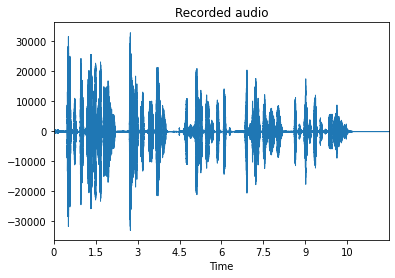

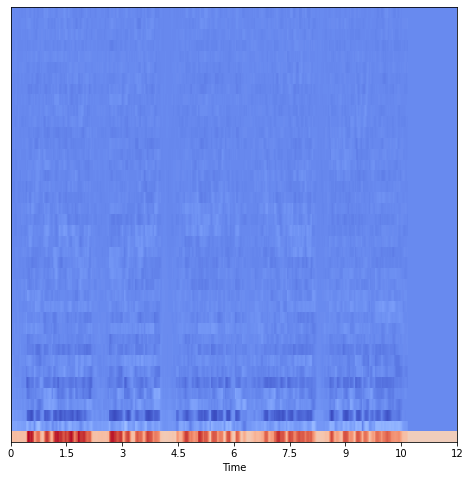

In [ ]:
test = record_audio()
test.shape

In [ ]:
testT = test.T
testT.shape

(517, 40)

In [ ]:
import tensorflow as tf
from tensorflow import keras
besty = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_cnnlstm.h5')

In [ ]:
labels = ['angry','happy','neutral','sad']
temparr =  model.predict({"cnn-mfcc": test.reshape(1,40,517), "lstm-mfcc": testT.reshape(1,517,40)})
print(f'Emotion of the speech most possibly is ... {labels[np.argmax(temparr)]}')
print(temparr)

Emotion of the speech most possibly is ... sad
[[3.2449683e-19 8.0945647e-08 9.6558372e-04 9.9903429e-01]]
